In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
#autoreload 2：装入所有 %aimport 不包含的模块。
%autoreload 2          

np.random.seed(1)


In [11]:
# 使用np.pad函数
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a.shape)
b = np.pad(a,((2, 2), (1, 1)),"constant")
print("填充后的值：\n", b)

# pad里的元组（（），（））是对应原函数的维度来说的，元组第一维表示第一维，以此类推，比如（（x，y））就是
# 在第一维前后或上下填x和y个0.

(3, 3)
填充后的值：
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 2 3 0]
 [0 4 5 6 0]
 [0 7 8 9 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


## 前向传播

### 卷积前向传播

In [19]:
# 零填充
def zero_pad(X,pad):
    
    """
        参数：
            X - 为一个四维的图像数据，包括（批次数，高，长，通道）
            pad - 选择填充的0的个数
        
        返回：
            after_pad - 填充后的图片数据
    """
    
    after_pad = np.pad(X,(
                      (0,0),#批次之间不填充
                      (pad,pad),#图像的高填充
                      (pad,pad),#图像的宽填充
                      (0,0),),
                      "constant")# 通道数之间不填充
    
    return after_pad

x.shape = (4, 3, 3, 2)
x_paded.shape = (4, 7, 7, 2)
x[1, 1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_paded[1, 1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


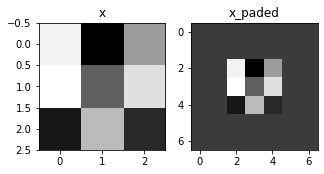

In [22]:
#测试
np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_paded = zero_pad(x,2)
#查看信息
print ("x.shape =", x.shape)
print ("x_paded.shape =", x_paded.shape)
print ("x[1, 1] =", x[1, 1])
print ("x_paded[1, 1] =", x_paded[1, 1])

#绘制图
fig , axarr = plt.subplots(1,2)  #一行两列
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_paded')
axarr[1].imshow(x_paded[0,:,:,0])
# 图为1张3*3的1通道的图

In [27]:
# 实现滤波器
def conv_single_step(X,w,b):
    """
        先将滤波器与图片像素进行点乘，并添加一个偏置，之后将各个更新后的像素值进行相加
        参数：
            X - 一个图片中的一部份与滤波器同样大小的图块切片
            w - 滤波器的权重
            b - 滤波器的偏置
        
        返回：
            z - 图块经过滤波后所生成的单个特征值
    """
    s = np.multiply(X, w) + b
    z = np.sum(s)
    return z

In [28]:
np.random.seed(1)

#这里切片大小和过滤器大小相同
a_slice_prev = np.random.randn(4,4,3)
W = np.random.randn(4,4,3)
b = np.random.randn(1,1,1)

Z = conv_single_step(a_slice_prev,W,b)

print("Z = " + str(Z))

Z = -23.16021220252078


In [57]:
# 卷积函数前向传播
def conv_forward(A_prev, W, b, hparameters):
    """
        参数：
            A_prev - 上一层激活后的参数维度为（m,h,w,c）分别代表样本数，图片高度，图片宽度，以及通道数   
            W - 过滤器的权重维度为（fh,fw,c_prev,n_c）分别为滤波器的宽，滤波器的长，上一层的通道数，本层的通道数或本层滤波器的个数
            b - 过滤器的偏置维度为（1，1，1, n_c）每个过滤器都有一个偏置
            hparameters - pad所需的步长，以及padding的个数
        
        返回：
            Z - 卷积后的特征图（m，n_h, n_w, n_c）分别为样本数，本层的高，本层的宽，本层的通道数或滤波器数量
            cache - 用于反向传播的一些参数
    """
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # 获得padding后的图像
    A_prev_pad = zero_pad(A_prev,pad)
    
    # 初始化当前层的输出
    m, prev_h, prev_w, prev_c = A_prev.shape
    f_h, f_w, pre_c, n_c = W.shape
        # 计算当前层输出的长宽,通过int向下取整
    n_h = int((prev_h + 2 * pad - f_h) / stride) + 1
    n_w = int((prev_w + 2 * pad - f_w) / stride) + 1
        # 初始化
    Z = np.zeros((m, n_h, n_w, n_c))
    
    # 开始进行卷积
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_h):
            for w in range(n_w):
                for c in range(n_c):
                    # 找切片中的位置
                    cut_h_start = h * stride
                    cut_h_end = cut_h_start + f_h
                    cut_w_start = w * stride
                    cut_w_end =  cut_w_start + f_w
                    # 提取切片信息
                    # 每次pooling都是进行的立方体块即多张图块的运行，是多张图块的权重与多张图片进行点乘
                    x = a_prev_pad[cut_h_start : cut_h_end,
                                  cut_w_start : cut_w_end,
                                  :]
                    # 当前这个过滤器中的高与宽
                    Z[i,h,w,c] = conv_single_strp(x, W[:, :, :, c], b[0, 0, 0, c])
                    
    # 验证数据格式
    assert(Z.shape == (m, n_h,n_w,n_c))
                    
    # 用于反向传播使用
    cache = (A_prev, W, b, hparameters)
    return Z, cache

In [58]:
# 测试
np.random.seed(1)

A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)

hparameters = {"pad" : 2, "stride": 1}

Z , cache_conv = conv_forward(A_prev,W,b,hparameters)

print("np.mean(Z) = ", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])


np.mean(Z) =  0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


### 池化层前向传播

In [97]:
# 池化层
def pool_forward(A_prev, hparameters, mode="max"):
    """
        参数：
            A_prev - 上一层激活后的参数维度为（m,h,w,c）分别代表样本数，图片高度，图片宽度，以及通道数   
            hparameters - pooling所需的步长stride，以及size f
            model - 模型选择["max"|"average"]
        
        返回：
            A - 池化后的输出，维度为(m,n_h,n_w,n_c)
            cache - 用于反向传播的一些参数
    """
    
    m, prev_h, prev_w, prev_c = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # pooling 后的值
    n_h = int((prev_h - f)/ stride + 1)
    n_w = int((prev_w - f)/ stride + 1)
    
    # 初始化结果矩阵
    A = np.zeros((m, n_h, n_w, prev_c))
    for i in range(m):
        a_prev = A_prev[i]
        for h in range(n_h):
            for w in range(n_w):
                for c in range(prev_c):
                    # 确定切块
                    cut_h_start = h * stride    #竖向开始
                    cut_h_end = cut_h_start + f #竖向结束
                    cut_w_start = w * stride    #横向开始
                    cut_w_end = cut_w_start + f #横向结束
                    
                    # 一张一张的进行pooling，max计算的是每一张图上的最大值，而不是一个立方体中的最大值即多张图
                    x = a_prev[cut_h_start : cut_h_end,
                                  cut_w_start : cut_w_end,
                                  c]
                    
                    # 计算该色块的最大值
                    if mode == "max":
                        A[i, h, w, c] = np.max(x)
                    # 计算该色块的平均值
                    if mode == "average":
                        A[i, h, w, c] = np.mean(x)

    assert(A.shape == (m, n_h, n_w, prev_c))
    cache = (A_prev, hparameters)
    
    return A, cache

In [79]:
# 测试
np.random.seed(1)
A_prev = np.random.randn(2,4,4,3)
hparameters = {"f":4 , "stride":1}

A , cache = pool_forward(A_prev,hparameters,mode="max")

print("mode = max")
print("A =", A)
print("----------------------------")
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]
----------------------------
mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


## 反向传播

### 卷积层的反向传播

In [82]:
def conv_backward(dZ,cache):
    """
        卷积层的反向传播
        参数：
            dZ - 卷积层的输出（Z）的梯度，维度为（m，n_h, n_w, n_c）
            cache - 暂时存储的反向传播的所需参数
        
        返回：
            dA_prev - 卷积层输入（A_prev）的梯度，维度为（m，prev_h, prec_w, prev_c）
            dW - 卷积层过滤器权重的梯度维度为（f_h, f_w, prev_c, n_c）
            db - 卷积层过滤器偏置的梯度维度为（1，1，1，n_c）
            
    """
    # 获取cache的值
    A_prev, W, b, hparameters = cache
    
    m, prev_h, prev_w, prev_c = A_prev.shape
    
    m, n_h, n_w, n_c = dZ.shape
    
    f_h, f_w, prev_c, n_c = W.shape
    
    pad = hparameters["pad"]
    
    stride = hparameters["stride"]
    
    dA_prev = np.zeros((m, prev_h, prev_w, prev_c))
    dW = np.zeros((f_h, f_w, prev_c, n_c))
    db = np.zeros((1, 1, 1, n_c))
    
    #前向传播中我们使用了pad，反向传播也需要使用，这是为了保证数据结构一致
    A_prev_pad = zero_pad(A_prev,pad)
    dA_prev_pad = zero_pad(dA_prev,pad)
    
    # 处理数据
    for i in range(m):
        # 选择其中一个样本
        a_prev_pad = A_prev_pad[i]
        # 同样生成该样本的梯度
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_h):
            for w in range(n_w):
                for c in range(n_c):
                 # 确定切块
                    cut_h_start = h * stride      #竖向开始
                    cut_h_end = cut_h_start + f_h #竖向结束
                    cut_w_start = w * stride      #横向开始
                    cut_w_end = cut_w_start + f_w #横向结束
                    
                    a_slice = a_prev_pad[cut_h_start : cut_h_end,
                                  cut_w_start : cut_w_end,
                                  :]
                    
                    # 计算dA_prev,也就是下一层的dz，相当于dl的dA_pre
                    # 这一批过滤器（视频中的立方体）所对应的da_prev_pad
                    da_prev_pad[cut_h_start : cut_h_end,
                                  cut_w_start : cut_w_end,
                                  :] += W[:, :, :, c] * dZ[i, h, w, c]
                    
                    # 这一批的w和h
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[0, 0, 0, c] += dZ[i, h, w, c]
        
        # 该样本的最终dA_prev
        dA_prev[i, :, :, :] = da_prev_pad[pad : -pad, pad : -pad,: ]
        
    assert(dA_prev.shape == (m, prev_h, prev_w, prev_c))
    
    return dA_prev, dW, db
                    

In [83]:
np.random.seed(1)
#初始化参数
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2, "stride": 1}

#前向传播
Z , cache_conv = conv_forward(A_prev,W,b,hparameters)
#反向传播
dA , dW , db = conv_backward(Z,cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))


dA_mean = 9.608990675868995
dW_mean = 10.581741275547566
db_mean = 76.37106919563735


### 池化层反向传播

#### 最大值池化

In [85]:
def create_mask_from_window(x):
    """
        从输入矩阵中创建掩码，以保存最大值的矩阵的位置。
    
        参数：
            x - 一个维度为(f,f)的矩阵

        返回：
            mask - 包含x的最大值的位置的矩阵
    """
    mask = x == np.max(x)
    
    return mask


In [86]:
# 测试
np.random.seed(1)

x = np.random.randn(2,3)

mask = create_mask_from_window(x)

print("x = " + str(x)) 
print("mask = " + str(mask))

x = [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask = [[ True False False]
 [False False False]]


#### 平均值池化

In [93]:
def distribute_value(dz, shape):
    """
        给定一个值，为按矩阵大小平均分配到每一个矩阵位置中。

        参数：
            dz - 输入的实数
            shape - 元组，两个值，分别为n_H , n_W

        返回：
            a - 已经分配好了值的矩阵，里面的值全部一样。
    """
    
    w_h, w_w = shape
    
    average = dz / (w_h * w_w)
    
    a = np.ones(shape) * average
    
    return a

In [94]:
# 测试
dz = 2
shape = (2,2)

a = distribute_value(dz,shape)
print("a = " + str(a))

a = [[0.5 0.5]
 [0.5 0.5]]


In [104]:
# 反向传播
def pool_backward(dA,cache,mode = "max"):
    """
        参数：
            dA - 池化层输出值的梯度
            cache - 从前向传递存储的用来反向传播的参数
            mode - pooling所用到的模式
        
        返回：
            dA_prev - 池化层输入值的梯度
    """
    
    A_prev, hparameters = cache
    
    # pooling层的过滤器的大小f，步长stride
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    m, prev_h, prev_w, prev_c = A_prev.shape
    m, n_h, n_w, n_c = dA.shape
    
    dA_prev = np.zeros_like(A_prev)
    
    # 处理数据
    for i in range(m):
        for h in range(n_h):
            for w in range(n_w):
                for c in range(n_c):
                    # 确定切块
                    cut_h_start = h * stride      #竖向开始
                    cut_h_end = cut_h_start + f #竖向结束
                    cut_w_start = w * stride      #横向开始
                    cut_w_end = cut_w_start + f #横向结束
                    
                    a_slice = A_prev[i, cut_h_start : cut_h_end,
                                  cut_w_start : cut_w_end, c]
                    
                    if mode == "max":
                        # 相当于将dA_prev中除了最大值处都变为0
                        mask = create_mask_from_window(a_slice)
                        dA_prev[i, cut_h_start : cut_h_end,
                                  cut_w_start : cut_w_end, c] += np.multiply(mask, dA[i, h, w, c])
                    elif mode == "average":
                        # 获取当前过滤器pooling色块后的一个值
                        da = dA[i, h, w, c]
                        shape = (f,f)
                        # 相当于将原来的像素值转变为品均值
                        dA_prev[i,cut_h_start : cut_h_end,
                                  cut_w_start : cut_w_end, c] += distribute_value(da,shape)
    
    #数据处理完毕，开始验证格式
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [105]:
# 测试
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


## Tenserflow工具

In [106]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.python.framework import ops

import cnn_utils

%matplotlib inline
np.random.seed(1)

### 加载数据

y = 2


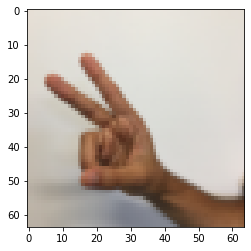

In [109]:
X_train_orig , Y_train_orig , X_test_orig , Y_test_orig , classes = cnn_utils.load_dataset()
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [110]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = cnn_utils.convert_to_one_hot(Y_train_orig, 6).T
Y_test = cnn_utils.convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### 构建模型

In [111]:
# 创建占位符
def create_placeholders(h, w, c, classes):
    """
        参数：
            h - 图像的高
            w - 图像的宽
            c - 图像的通道
            classes - 模型最终索要分的类型

        返回：
            X - 输入图像的占位符
            Y - 标签的占位符
    """
    
    X = tf.placeholder(tf.float32,[None, h, w, c])
    Y = tf.placeholder(tf.float32,[None,classes])
    
    return X, Y

In [112]:
#测试
X , Y = create_placeholders(64,64,3,6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [122]:
# 初始化参数
def initialize_params():
    """
        初始化权重，W1和W2，固定初始化：
        W1 [4,4,3,8]
        W2 [2,2,8,16]
        参数：
            无
        
        返回：
            params - 包括W1和W2的字典
    """
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {"W1" : W1, "W2" : W2}
    
    return parameters
    

In [123]:
# 测试
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_params()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))
    
    sess_test.close()

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [126]:
# 前向传播
def forward_propagation(X,parameters):
    """
        参数：
            X - 输入的图片数据占位符
            parameters - 过滤器的一些权重
        
        返回：
            Z3 - 最后一次激活后的值
    """
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    # 第一层卷积
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="SAME")
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding="SAME")
    
    # 第二层卷积
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding="SAME")  
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1],strides=[1,4,4,1], padding="SAME")
    
    # 全连接层
    P = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P,6,activation_fn=None)
    
    return Z3

In [132]:
# 测试
tf.reset_default_graph()
np.random.seed(1)

with tf.Session() as sess_test:
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_params()
    Z3 = forward_propagation(X,parameters)
    
    init = tf.global_variables_initializer()
    sess_test.run(init)
    
    a = sess_test.run(Z3,{X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))
    
    sess_test.close()


Z3 = [[ 1.4416982  -0.24909668  5.4504995  -0.2618962  -0.20669872  1.3654671 ]
 [ 1.4070847  -0.02573182  5.08928    -0.4866991  -0.4094069   1.2624853 ]]


In [129]:
# 计算成本
def compute_cost(Z3,Y):
    """
        参数：
            Z3 - 正向传播最后一次激活后的值 
            Y - 数据的标签
            
        返回：
            cost - 这一批次计算的成本
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=Z3))
    
    return cost

In [133]:
# 测试
tf.reset_default_graph()

with tf.Session() as sess_test:
    np.random.seed(1)
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_params()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    
    init = tf.global_variables_initializer()
    sess_test.run(init)
    a = sess_test.run(cost,{X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))
    
    sess_test.close()

cost = 4.6648703


In [148]:
# 构建模型
def model(X_train, Y_train, X_test, Y_test, lr=0.009, batch_size=64, epochs=100, print_cost=True, is_plt=True ):
    
    
    ops.reset_default_graph()  #能够重新运行模型而不覆盖tf变量
    tf.set_random_seed(1)    
    seed = 3                 #指定numpy的随机种子
    m, h, w, c = X_train.shape
    m, classes = Y_train.shape
    costs = []
    
    # 构建tensorflow的图
    X,Y = create_placeholders(h,w,c,classes)
    parameters = initailize_params()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    init = tf.global_variables_initializer()
    
    # 运行会话
    with tf.Session() as sess:
        sess.run(init)
        
        # 开始训练
        for i in range(epochs):
            seed = seed + 1
            epoch_cost = 0
            num_batch = m //batch_size
            batches = cnn_utils.random_mini_batches(X_train,Y_train,batch_size,seed)
            for batch in batches:
                x_batch,y_batch = batch
                _, batch_cost = sess.run([optimizer,cost],feed_dict={X:x_batch,Y:y_batch})
                epoch_cost += batch_cost / num_batch
            costs.append(epoch_cost)
            if i%5 == 0:
                if print_cost:
                    print("第%d次迭代的损失为：%f"%(i,epoch_cost))
        
        if is_plt:
            plt.plot(costs)
            plt.title("Cost_Learning rate({})".format(lr))
            plt.xlabel("Epochs")
            plt.ylabel("Cost")
            plt.show()
        
        acc_list = tf.equal(tf.argmax(Z3,1),tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(acc_list,tf.float32))
        
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuary = accuracy.eval({X: X_test, Y: Y_test})
        
        print("训练集准确度：" + str(train_accuracy))
        print("测试集准确度：" + str(test_accuary))
        
        return (train_accuracy,test_accuary,parameters)
    

第0次迭代的损失为：1.921332
第5次迭代的损失为：1.904156
第10次迭代的损失为：1.904309
第15次迭代的损失为：1.904477
第20次迭代的损失为：1.901876
第25次迭代的损失为：1.784077
第30次迭代的损失为：1.681053
第35次迭代的损失为：1.618208
第40次迭代的损失为：1.597973
第45次迭代的损失为：1.567265
第50次迭代的损失为：1.553831
第55次迭代的损失为：1.499270
第60次迭代的损失为：1.443608
第65次迭代的损失为：1.273833
第70次迭代的损失为：1.183423
第75次迭代的损失为：1.140219
第80次迭代的损失为：1.099051
第85次迭代的损失为：1.095431
第90次迭代的损失为：1.040229
第95次迭代的损失为：1.010761
第100次迭代的损失为：1.004779
第105次迭代的损失为：0.946490
第110次迭代的损失为：0.943555
第115次迭代的损失为：0.921020
第120次迭代的损失为：0.915435
第125次迭代的损失为：0.906684
第130次迭代的损失为：0.891546
第135次迭代的损失为：0.863266
第140次迭代的损失为：0.836714
第145次迭代的损失为：0.827909
第150次迭代的损失为：0.832611
第155次迭代的损失为：0.792830
第160次迭代的损失为：0.787734
第165次迭代的损失为：0.782323
第170次迭代的损失为：0.838590
第175次迭代的损失为：0.821936
第180次迭代的损失为：0.809865
第185次迭代的损失为：0.758370
第190次迭代的损失为：0.744009
第195次迭代的损失为：0.756832
第200次迭代的损失为：0.765710
第205次迭代的损失为：0.736523
第210次迭代的损失为：0.748534
第215次迭代的损失为：0.708796
第220次迭代的损失为：0.704896
第225次迭代的损失为：0.710206
第230次迭代的损失为：0.694231
第235次迭代的损失为：0.698420
第240次迭代的损失为：0.

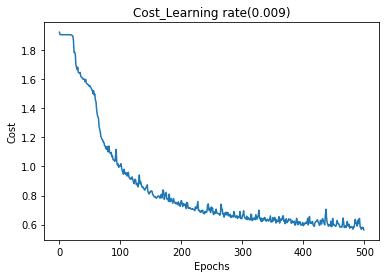

训练集准确度：0.8046296
测试集准确度：0.725


In [150]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,epochs=500)